This models the pricing conversions we need to do from *Binary Price* to fixed point.
BinaryPrice data type is defined as 2's compliment 64 bit number with 4 decimal points implied.
For example 123400 means 12.34 in $s. 

I ran these simulations in conda environment *hwlib*

binprice:  -502348545294763747


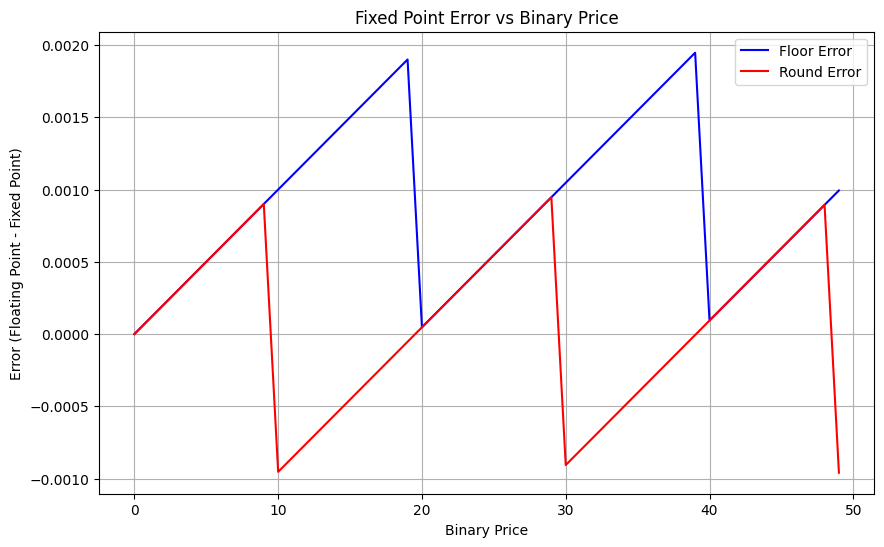

Maximum Floor Error:  0.0019468749999999998
Minimum Floor Error:  0.0
Maximum Round Error:  0.0009468749999999998
Minimum Round Error:  -0.0009593750000000002


In [15]:
import random
import math 
import matplotlib.pyplot as plt
binprice = random.randint(-2**63, 2**63-1) # generate a random 64-bit signed integer

flt_cents = binprice / 100.0 # convert to float
print("binprice: ", binprice)
flt_dollars = binprice / 10000.0 # convert to float

FRAC_BITS = 9
MAX_BIN_PRICE = 50 
MIN_BIN_PRICE = 0
fxp_err_floor = []
fxp_err_round = []
binprices = []
for binprice in range(MIN_BIN_PRICE, MAX_BIN_PRICE):
    flt_dollar = binprice / 10000.0 # convert to float
    fxp_price_floor = math.floor(flt_dollar * 2**FRAC_BITS)/2**FRAC_BITS # convert to fixed point decimal
    fxp_err_floor.append(flt_dollar - fxp_price_floor)

    fxp_price_round = round(flt_dollar * 2**FRAC_BITS)/2**FRAC_BITS # convert to fixed point decimal
    fxp_err_round.append(flt_dollar - fxp_price_round)

    binprices.append(binprice)

plt.figure(figsize=(10, 6))
plt.plot(binprices, fxp_err_floor, label="Floor Error", color="blue")  # Plot fxp_err_floor
plt.plot(binprices, fxp_err_round, label="Round Error", color="red")   # Plot fxp_err_round
plt.xlabel("Binary Price")
plt.ylabel("Error (Floating Point - Fixed Point)")
plt.title("Fixed Point Error vs Binary Price")
plt.legend()  # Add legend to distinguish the plots
plt.grid(True)
plt.show()

print("Maximum Floor Error: ", max(fxp_err_floor))
print("Minimum Floor Error: ", min(fxp_err_floor))
print("Maximum Round Error: ", max(fxp_err_round))
print("Minimum Round Error: ", min(fxp_err_round))


In the next section we want to visualize how much the error reduce for every bit of precision added.

FRAC_BITS=5 max error: 0.03125
FRAC_BITS=6 max error: 0.015625
FRAC_BITS=7 max error: 0.0078125
FRAC_BITS=8 max error: 0.00390625
FRAC_BITS=9 max error: 0.001953125
FRAC_BITS=10 max error: 0.0009765625


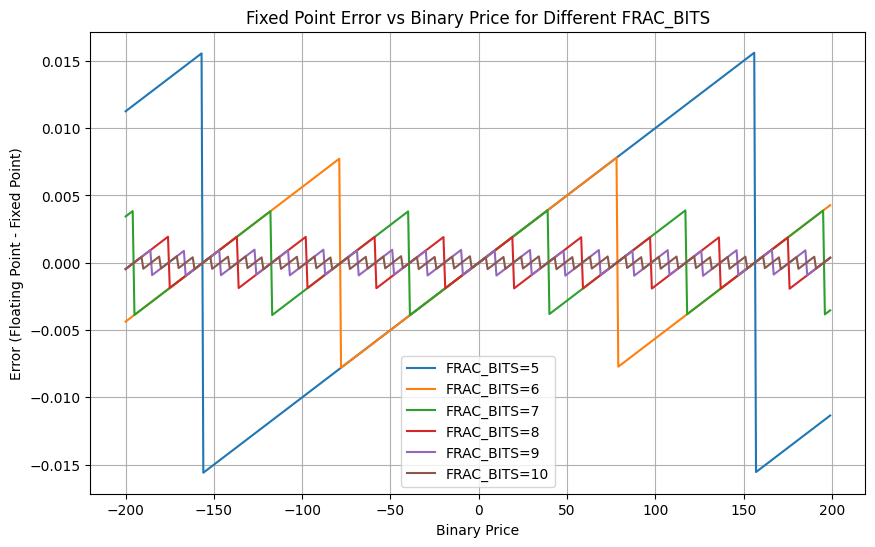

In [13]:
FRAC_BITS = 8
FRAC_BITS_RANGE = 3 # go from 5 to 11
MAX_BIN_PRICE = 200
MIN_BIN_PRICE = -200
fxp_err_floor = []
fxp_err_round = []
binprices = [binprice for binprice in range(MIN_BIN_PRICE, MAX_BIN_PRICE)]


for frac_bits in range(FRAC_BITS - FRAC_BITS_RANGE, FRAC_BITS + FRAC_BITS_RANGE):
    temp = []
    for binprice in binprices:
        flt_dollar = binprice / 10000.0 # convert to float
        fxp_price_round = round(flt_dollar * 2**frac_bits)/2**frac_bits # convert to fixed point decimal
        temp.append(flt_dollar - fxp_price_round)
    fxp_err_round.append(temp)
    print(f"FRAC_BITS={frac_bits} max error: {1/2**frac_bits}")

# Plot each list in fxp_err_round
plt.figure(figsize=(10, 6))
for i, err_list in enumerate(fxp_err_round):
    plt.plot(binprices, err_list, label=f"FRAC_BITS={5 + i}")  # Add a label for each line

# Add labels, title, and legend
plt.xlabel("Binary Price")
plt.ylabel("Error (Floating Point - Fixed Point)")
plt.title("Fixed Point Error vs Binary Price for Different FRAC_BITS")
plt.legend()
plt.grid(True)
plt.show()

The way you need to understand the above plot is as we are moving in decimal from -200/10000 to 200/10000 by steps of 0.0001 the fixed point representation will have an error and this error (i.e. quantization error) will be a max of -1/2^(frac_bits+1) to +1/2^(frac_bits+1).

A good way to vizualize is that imagine you have quantization level steps. For example if you have 9 bits of precision, then every step would be of value 1/2^9 = 0.001953125. So the series of steps are {0, 0.001953125, 2x0.001953125, 3x0.001953125 ...} so on and so forth. If you want to represent 0.0001, its clear you cannot. Quantization and rounding will place 0.0001, 0.0002 so an so forth either to 0 or to 0.001953125 whichever is closer. 

So hypothetically what we want to do in hardware is when we get a binaryprice we want to divide it by 10^4 and shift it up by 2**frac_bits. We then want to round the result (not truncate) to limit the error in range described above.

So how do we figure out what this Scale is. What is the measure of error? How do we characterize this?



In [23]:
from decimal import Decimal
max_binprice = 2**(63)-1
max_flt_dollar = Decimal(max_binprice) / Decimal(10000.0) # convert to float
flt_scale = 512/10000.0
print(f"max_binprice:  {max_binprice:,d}")   
print(f"max_flt_dollar: {max_flt_dollar:,.16f}")
print(f"flt_scale:      {flt_scale:,.16f}")

for i in range(16, 32):
    scale_in_flt = flt_scale * 2**i
    scale_int = int(scale_in_flt)
    print(f"i: {i} scale_in_flt: {scale_in_flt:,.16f} scale_int: {scale_int:,d}")


max_binprice:  9,223,372,036,854,775,807
max_flt_dollar: 922,337,203,685,477.5807000000000000
flt_scale:      0.0512000000000000
i: 16 scale_in_flt: 3,355.4432000000001608 scale_int: 3,355
i: 17 scale_in_flt: 6,710.8864000000003216 scale_int: 6,710
i: 18 scale_in_flt: 13,421.7728000000006432 scale_int: 13,421
i: 19 scale_in_flt: 26,843.5456000000012864 scale_int: 26,843
i: 20 scale_in_flt: 53,687.0912000000025728 scale_int: 53,687
i: 21 scale_in_flt: 107,374.1824000000051456 scale_int: 107,374
i: 22 scale_in_flt: 214,748.3648000000102911 scale_int: 214,748
i: 23 scale_in_flt: 429,496.7296000000205822 scale_int: 429,496
i: 24 scale_in_flt: 858,993.4592000000411645 scale_int: 858,993
i: 25 scale_in_flt: 1,717,986.9184000000823289 scale_int: 1,717,986
i: 26 scale_in_flt: 3,435,973.8368000001646578 scale_int: 3,435,973
i: 27 scale_in_flt: 6,871,947.6736000003293157 scale_int: 6,871,947
i: 28 scale_in_flt: 13,743,895.3472000006586313 scale_int: 13,743,895
i: 29 scale_in_flt: 27,487,790.6944